## What is Keras?

[Keras](https://keras.io/) is a high level Neural Network API that is simple to use. It is able to run on top of many libraries such as Tensorflow, Theano, and CNTK.



See: https://keras.io/#getting-started-30-seconds-to-keras

# Semantic Segmentation in Keras

segnet architecture code from: https://github.com/divamgupta/image-segmentation-keras

## Setup

In [1]:
import os
# Tell theano to use our GPU
os.environ['THEANO_FLAGS'] = "device=gpu0"

import keras
import theano
import numpy as np
from skimage.io import imread, imshow

%matplotlib inline
from matplotlib import pyplot as plt, rcParams, rc

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)


In [2]:
path = 'C:\\Users\\Computer\\Documents\\undergrad-research\\data\\crack\\'

path_img = path + 'train_only_crack\\'
path_img_gt = path + 'train_gt_only_crack\\'

path_val = path + 'valid_only_crack\\'
path_val_gt = path + 'valid_gt_only_crack\\'

print('Paths:')
print('\n'.join([path, path_img, path_img_gt, path_val, path_val_gt]))

Paths:
C:\Users\Computer\Documents\undergrad-research\data\crack\
C:\Users\Computer\Documents\undergrad-research\data\crack\train_only_crack\
C:\Users\Computer\Documents\undergrad-research\data\crack\train_gt_only_crack\
C:\Users\Computer\Documents\undergrad-research\data\crack\valid_only_crack\
C:\Users\Computer\Documents\undergrad-research\data\crack\valid_gt_only_crack\


In [3]:
# plots: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/convolution-intro.ipynb
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)
        
def get_images(path, path_gt, amount = None):
    data = []
    gt   = []
    
    data_filenames = os.listdir(path)
    gt_filenames   = os.listdir(path_gt)
    
    data_amount = len(data_filenames)
    assert data_amount == len(gt_filenames)
    
    if not amount:
        amount = data_amount
    
    for i in range(amount):
        data_path = path    + data_filenames[i]
        gt_path   = path_gt + gt_filenames[i]
        
        data.append(imread(data_path))
        gt.append(imread(gt_path))
        
    return np.array(data), np.array(gt)

## Example Data

As you can tell, some of the cracks are quite hard to spot.

In [4]:
data, gt = get_images(path_img, path_img_gt, amount = 4)

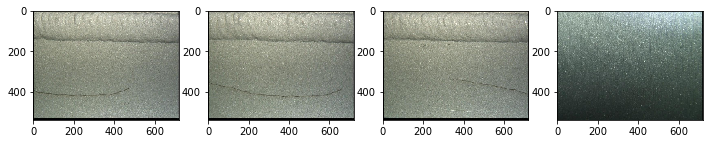

In [5]:
plots(data)

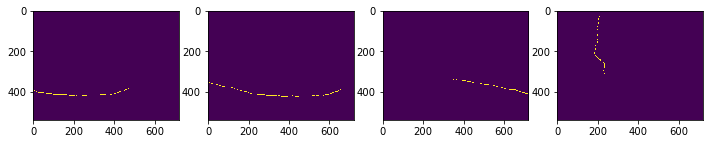

In [6]:
plots(gt)

## Simple SegNet

In [7]:
import Segnet
import LoadBatches

#### View the source

In [ ]:
??Segnet

In [ ]:
??LoadBatches.imageSegmentationGenerator

#### Load the data

In [8]:
new_x = 536
new_y = 720
batch_size = 2
n_classes = 2

G = LoadBatches.imageSegmentationGenerator(path_img, path_img_gt, batch_size, n_classes,
                                           new_x, new_y, new_x, new_y)

In [9]:
X, Y = next(G)
print(X.shape, Y.shape)

(2, 3, 536, 720) (2, 385920, 2)


In [10]:
print(Y[0].shape)
test = Y[0]
print('Amount of cracks', np.sum(Y[0][:, 1]), 'total pixels:', len(Y[0]))

(385920, 2)
Amount of cracks 1386.0 total pixels: 385920


#### Creating a model

In [11]:
from keras.optimizers import Adam
model = Segnet.segnet(n_classes, optimizer = Adam(), input_height = new_x, input_width = new_y)

th


C:\Users\Computer\Anaconda3\lib\site-packages\keras\engine\topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_1_model" was not an Input tensor, it was generated by layer layer_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: layer_input_1
  str(x.name))


In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
layer_1 (Layer)                  (None, 3, 536, 720)   0           layer_input_1[0][0]              
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 538, 722)   0           layer_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 536, 720)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 64, 536, 720)  2880        convolution2d_1[0][0]            
___________________________________________________________________________________________

### Compute class weights

In [12]:
def median_freq_weights(x_dim, y_dim, n_classes):
    _, gt = get_images(path_img, path_img_gt)
    
    class_counts = {c : 0 for c in range(n_classes)}    
    image_size = x_dim * y_dim
    
    for gt_img in gt:
        for c in range(n_classes):
            amount_class_c = np.sum(np.where(gt_img == c))
            class_counts[c] += amount_class_c     
        
    class_frequency = {k : (v/image_size) for k , v in class_counts.items()}
    
    median_frequency = sum(class_frequency.values()) / 2
    return {k : (median_frequency / v) for k, v in class_frequency.items()}

In [13]:
w = median_freq_weights(540, 720, n_classes)
class_weights = np.zeros((new_x * new_y, n_classes))
for c in range(n_classes):
    print(c, w[c])
    class_weights[:, c] += w[c]

0 0.501230454324
1 203.676985155


### Train our model

In [52]:
model.fit_generator( G , 512  , nb_epoch=5 , class_weight  = class_weights)
model.save_weights('weights_model1')
model.save('model1')

Epoch 1/5
512/512 [==============================] - 480s - loss: 0.0065 - binary_accuracy: 0.9978   
Epoch 2/5
512/512 [==============================] - 482s - loss: 0.0060 - binary_accuracy: 0.9979   
Epoch 3/5
512/512 [==============================] - 481s - loss: 0.0056 - binary_accuracy: 0.9980   
Epoch 4/5
512/512 [==============================] - 482s - loss: 0.0053 - binary_accuracy: 0.9981   
Epoch 5/5
512/512 [==============================] - 483s - loss: 0.0051 - binary_accuracy: 0.9981   


In [26]:
X, Y = next(G)

(3, 536, 720)
(536, 720, 3)


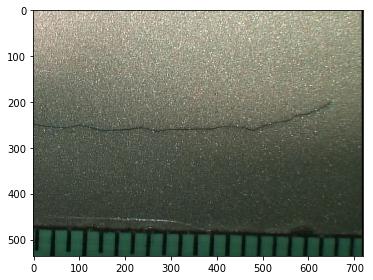

In [47]:
idx = 1

print(X[idx].shape)
rollax = np.rollaxis(X[idx].copy(), 0, 3)
print(rollax.shape)

# In our preprocessing, we subtract the mean to help our network. Add it back here.
rollax[:,:,0] += 103.939
rollax[:,:,1] += 116.779
rollax[:,:,2] += 123.68

imshow(np.uint8(np.abs(rollax)))

(385920, 2)
(536, 720)


C:\Users\Computer\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


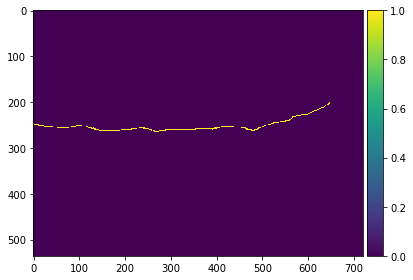

In [48]:
gt = Y[idx].copy()
print(gt.shape)
gt = gt.reshape(( new_x ,  new_y , 2 ) ).argmax( axis=2 )
print(gt.shape)
imshow(gt)

In [49]:
pred = model.predict(X)

In [50]:
apred = pred[idx]
apred[:, 0] = np.uint8(pred[idx][:, 0] > 0.5)
apred = apred.reshape(( new_x ,  new_y , 2 ) ).argmax( axis=2 )

print(apred.shape)

(536, 720)


C:\Users\Computer\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


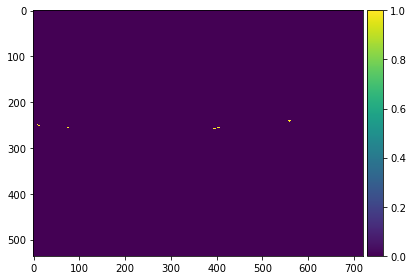

In [51]:
imshow(apred)